In [1]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split

from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.tsa.stattools import adfuller

import warnings # necessary b/c pandas & statsmodels datetime issue
warnings.simplefilter(action="ignore")

In [2]:
df = pd.read_csv('./Sample_Superstore.csv', encoding='windows-1252')
df.head()

,Row ID,Order ID,Order Date,Ship Date,Ship Mode,Customer ID,Customer Name,Segment,Country,City,...,Postal Code,Region,Product ID,Category,Sub-Category,Product Name,Sales,Quantity,Discount,Profit
0,1,CA-2016-152156,11/8/2016,11/11/2016,Second Class,CG-12520,Claire Gute,Consumer,United States,Henderson,...,42420,South,FUR-BO-10001798,Furniture,Bookcases,Bush Somerset Collection Bookcase,261.9600,2,0.00,41.9136
1,2,CA-2016-152156,11/8/2016,11/11/2016,Second Class,CG-12520,Claire Gute,Consumer,United States,Henderson,...,42420,South,FUR-CH-10000454,Furniture,Chairs,"Hon Deluxe Fabric Upholstered Stacking Chairs,...",731.9400,3,0.00,219.5820
2,3,CA-2016-138688,6/12/2016,6/16/2016,Second Class,DV-13045,Darrin Van Huff,Corporate,United States,Los Angeles,...,90036,West,OFF-LA-10000240,Office Supplies,Labels,Self-Adhesive Address Labels for Typewriters b...,14.6200,2,0.00,6.8714
3,4,US-2015-108966,10/11/2015,10/18/2015,Standard Class,SO-20335,Sean O'Donnell,Consumer,United States,Fort Lauderdale,...,33311,South,FUR-TA-10000577,Furniture,Tables,Bretford CR4500 Series Slim Rectangular Table,957.5775,5,0.45,-383.0310
4,5,US-2015-108966,10/11/2015,10/18/2015,Standard Class,SO-20335,Sean O'Donnell,Consumer,United States,Fort Lauderdale,...,33311,South,OFF-ST-10000760,Office Supplies,Storage,Eldon Fold 'N Roll Cart System,22.3680,2,0.20,2.5164


In [3]:
df.shape

(9994, 21)

In [4]:
df.describe()

,Row ID,Postal Code,Sales,Quantity,Discount,Profit
count,9994.000000,9994.000000,9994.000000,9994.000000,9994.000000,9994.000000
mean,4997.500000,55190.379428,229.858001,3.789574,0.156203,28.656896
std,2885.163629,32063.693350,623.245101,2.225110,0.206452,234.260108
min,1.000000,1040.000000,0.444000,1.000000,0.000000,-6599.978000
25%,2499.250000,23223.000000,17.280000,2.000000,0.000000,1.728750
50%,4997.500000,56430.500000,54.490000,3.000000,0.200000,8.666500
75%,7495.750000,90008.000000,209.940000,5.000000,0.200000,29.364000
max,9994.000000,99301.000000,22638.480000,14.000000,0.800000,8399.976000


In [5]:
df.isnull().sum()

Row ID           0
Order ID         0
Order Date       0
Ship Date        0
Ship Mode        0
Customer ID      0
Customer Name    0
Segment          0
Country          0
City             0
State            0
Postal Code      0
Region           0
Product ID       0
Category         0
Sub-Category     0
Product Name     0
Sales            0
Quantity         0
Discount         0
Profit           0
dtype: int64

In [6]:
df.dtypes

Row ID             int64
Order ID          object
Order Date        object
Ship Date         object
Ship Mode         object
Customer ID       object
Customer Name     object
Segment           object
Country           object
City              object
State             object
Postal Code        int64
Region            object
Product ID        object
Category          object
Sub-Category      object
Product Name      object
Sales            float64
Quantity           int64
Discount         float64
Profit           float64
dtype: object

### EDA

In [7]:
no_discounts = df.loc[(df.Discount == 0.00)]
no_discounts.groupby('Category')['Profit'].mean()

Category
Furniture           69.537173
Office Supplies     41.708567
Technology         158.881657
Name: Profit, dtype: float64

In [8]:
df.groupby('Category')['Profit'].describe().T

Category,Furniture,Office Supplies,Technology
count,2121.000000,6026.00000,1847.000000
mean,8.699327,20.32705,78.752002
std,136.049246,164.88728,428.816633
min,-1862.312400,-3701.89280,-6599.978000
25%,-12.849000,2.10150,5.203650
50%,7.774800,6.88240,25.018200
75%,33.726600,19.41630,74.894600
max,1013.127000,4946.37000,8399.976000


In [9]:
df[['Category', 'Profit', 'Sales', 'Discount', 'Quantity']].sort_values(['Category', 'Profit']).head(20)

,Category,Profit,Sales,Discount,Quantity
9639,Furniture,-1862.3124,4297.644,0.40,13
27,Furniture,-1665.0522,3083.430,0.50,7
5320,Furniture,-1002.7836,2314.116,0.40,7
8993,Furniture,-968.8833,1875.258,0.40,7
463,Furniture,-814.4832,1272.630,0.50,6
1369,Furniture,-786.7440,590.058,0.70,7
6639,Furniture,-734.5264,1421.664,0.40,8
5066,Furniture,-653.2834,1781.682,0.40,7
7243,Furniture,-630.8820,4416.174,0.30,9
949,Furniture,-619.5960,2065.320,0.40,12


In [10]:
df.loc[(df['Profit'] < 0) & (df['Discount'] == 0.00)]

,Row ID,Order ID,Order Date,Ship Date,Ship Mode,Customer ID,Customer Name,Segment,Country,City,...,Postal Code,Region,Product ID,Category,Sub-Category,Product Name,Sales,Quantity,Discount,Profit


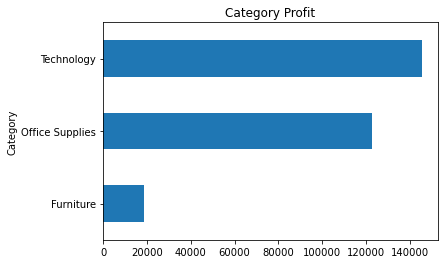

In [11]:
df.groupby('Category')['Profit'].sum().plot(kind='barh',title='Category Profit');

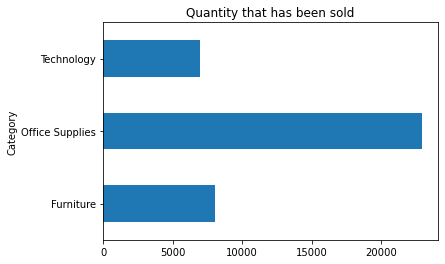

In [12]:
df.groupby('Category')['Quantity'].sum().plot(kind='barh',title='Quantity that has been sold');

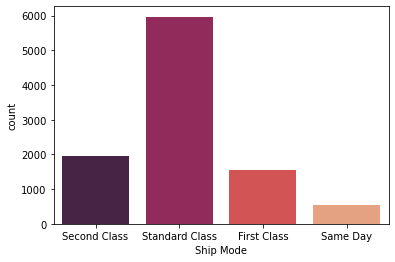

In [13]:
sns.countplot(x=df['Ship Mode'],palette='rocket');

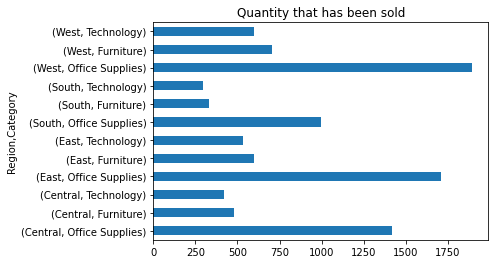

In [14]:
df.groupby('Region')['Category'].value_counts().plot(kind='barh',title='Quantity that has been sold');

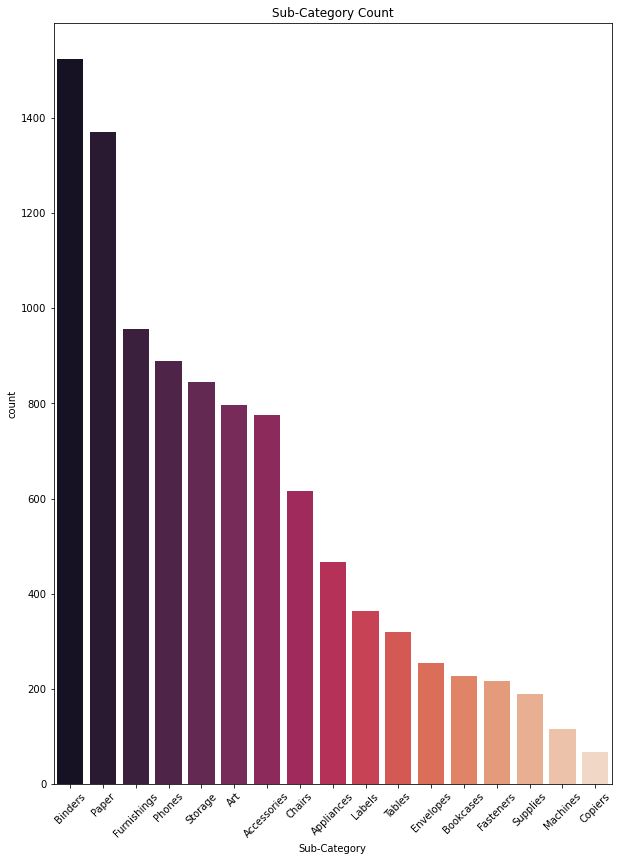

In [15]:
plt.figure(figsize=(10,14))
sns.countplot(x=df['Sub-Category'],order=df['Sub-Category'].value_counts().index, palette='rocket')
plt.xticks(rotation=45)
plt.title("Sub-Category Count");

#### Set up data for modeling

In [17]:
df = df[['Order Date', 'Sales']]
df.head()

,Order Date,Sales
0,11/8/2016,261.9600
1,11/8/2016,731.9400
2,6/12/2016,14.6200
3,10/11/2015,957.5775
4,10/11/2015,22.3680


In [18]:
df['Order Date'] = pd.to_datetime(df['Order Date'])

In [19]:
df = df.resample('W-Mon', on='Order Date').sum().reset_index().sort_values(by='Order Date')

In [20]:
df.shape

(209, 2)

In [21]:
df.dtypes

Order Date    datetime64[ns]
Sales                float64
dtype: object

In [22]:
df.set_index('Order Date', inplace=True)
df.sort_index(inplace=True)

In [23]:
df.head()

,Sales
Order Date,
2014-01-06,4731.144
2014-01-13,3746.267
2014-01-20,3629.202
2014-01-27,1595.188
2014-02-03,1312.752


In [24]:
df.shape

(209, 1)

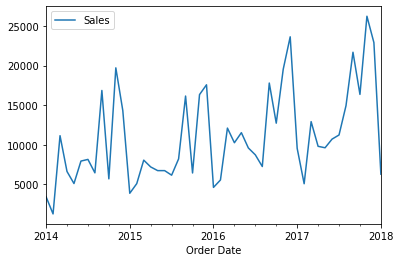

In [25]:
df.resample('M')[['Sales']].mean().plot();

In [26]:
df.rolling(3).mean()

,Sales
Order Date,
2014-01-06,NaN
2014-01-13,NaN
2014-01-20,4035.537667
2014-01-27,2990.219000
2014-02-03,2179.047333
...,...
2017-12-04,27930.819933
2017-12-11,25428.156000
2017-12-18,22961.716000


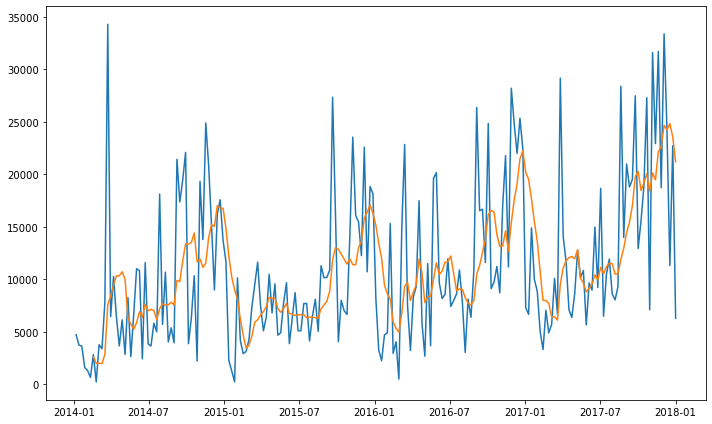

In [27]:
plt.figure(figsize=(10,6))
plt.plot(df['Sales'])
plt.plot(df['Sales'].rolling(7).mean())
# plt.xticks(rotation=45);
plt.tight_layout();

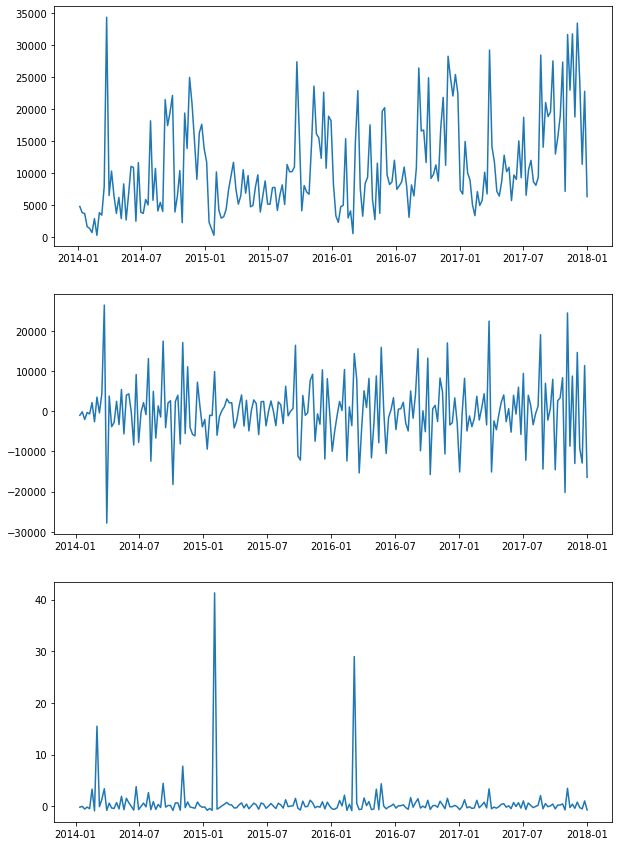

In [28]:
fig, axes = plt.subplots(nrows=3, figsize=(10, 15))
axes[0].plot(df['Sales'])
axes[1].plot(df['Sales'].diff())
axes[2].plot(df['Sales'].pct_change());

### Predict Profit for the next 7 days

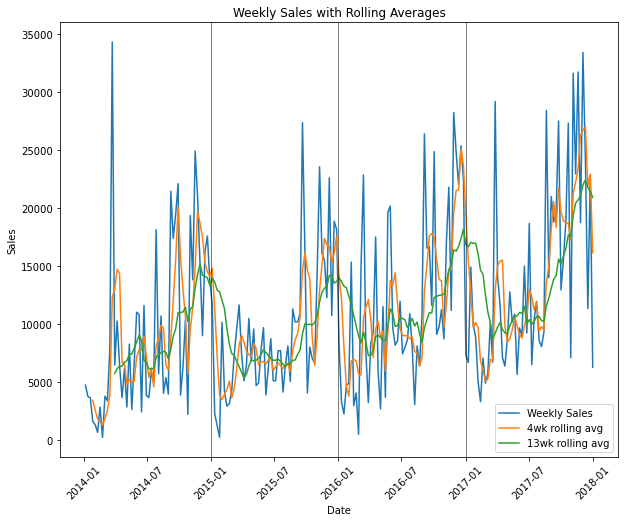

In [34]:
plt.figure(figsize = (10,8))
plt.plot(df['Sales'])
plt.plot(df['Sales'].rolling(4).mean())
plt.plot(df['Sales'].rolling(13).mean())
plt.title('Weekly Sales with Rolling Averages')
plt.xticks(rotation = 45)
plt.axvline(x=['2015-01'], linewidth = 0.5, color='k')
plt.axvline(x=['2016-01'], linewidth = 0.5, color='k')
plt.axvline(x=['2017-01'], linewidth = 0.5, color='k')
plt.xlabel('Date')
plt.ylabel('Sales')
plt.legend(['Weekly Sales', '4wk rolling avg', '13wk rolling avg']);

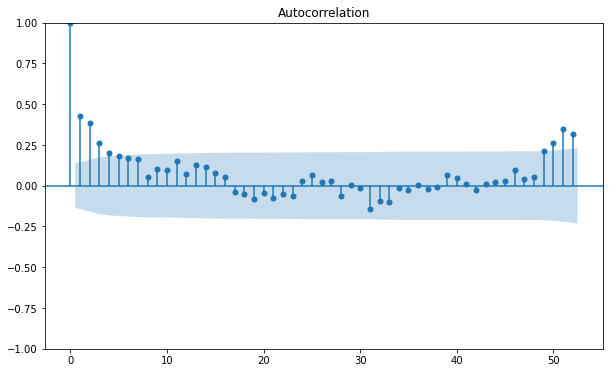

In [35]:
plt.rcParams['figure.figsize'] = (10, 6)
plot_acf(df['Sales'], lags=52);

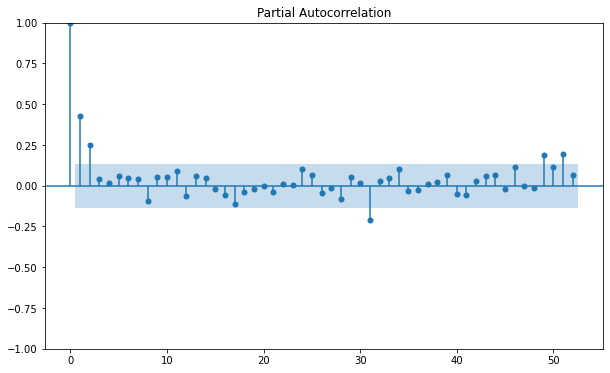

In [36]:
plot_pacf(df['Sales'], lags=52);

#### Modeling

In [37]:
df.head()

,Sales
Order Date,
2014-01-06,4731.144
2014-01-13,3746.267
2014-01-20,3629.202
2014-01-27,1595.188
2014-02-03,1312.752


In [38]:
y_train, y_test = train_test_split(df['Sales'], test_size=0.1, shuffle=False, random_state=42)

In [42]:
y_train.shape, y_test.shape

((188,), (21,))

In [43]:
adfuller(df['Sales'])

(-5.9706492081907045,
 1.939912900601648e-07,
 1,
 207,
 {'1%': -3.4623415245233145,
  '5%': -2.875606128263243,
  '10%': -2.574267439846904},
 3931.6681777109857)

In [92]:
def interpret_dftest(dftest):
    dfoutput = pd.Series(dftest[0:2], index=['Test Statistic','p-value'])
    p_without = f'p-value without scientific notation:' "{:.17f}".format(float(dfoutput[1]))
    return dfoutput, p_without

In [93]:
interpret_dftest(adfuller(df['Sales']))

(Test Statistic   -5.970649e+00
 p-value           1.939913e-07
 dtype: float64,
 'p-value without scientific notation:0.00000019399129006')

#### Since p-value is less than .05, we do not need to diff 

In [94]:
# Starting AIC, p, and q.
best_aic = 99 * (10 ** 16)
best_p = 0
best_q = 0
combo_score = []

# Use nested for loop to iterate over values of p and q.
for p in range(5):
    for q in range(5):
        
        # Insert try and except statements.
        try:
            
            # Fitting an ARIMA(p, 1, q) model.
            print(f'Attempting ARIMA({p}, 1, {q})')
            
            # Instantiate ARIMA model.
            arima = ARIMA(endog=y_train, order=(p, 1, q))
            
            
            # Fit ARIMA model.
            model = arima.fit()

            # Print out AIC for ARIMA(p, 1, q) model.
            print(f'The AIC for ARIMA({p},1,{q}) is: {model.aic}')
            combo_score.append((model.aic, (p,1,q)))

            # Is my current model's AIC better than our best_aic?
            if model.aic < best_aic:
                
                # If so, let's overwrite best_aic, best_p, and best_q.
                best_aic = model.aic
                best_p = p
                best_q = q

        except:
            pass
print()
print()
print('MODEL FINISHED!')
print(f'Our model that minimizes AIC on the training data is the ARIMA({best_p},1,{best_q}).')
print(f'This model has an AIC of {best_aic}.')

Attempting ARIMA(0, 1, 0)
The AIC for ARIMA(0,1,0) is: 3858.3552020931943
Attempting ARIMA(0, 1, 1)
The AIC for ARIMA(0,1,1) is: 3808.588924820624
Attempting ARIMA(0, 1, 2)
The AIC for ARIMA(0,1,2) is: 3803.298494286102
Attempting ARIMA(0, 1, 3)
The AIC for ARIMA(0,1,3) is: 3799.3007409841994
Attempting ARIMA(0, 1, 4)
The AIC for ARIMA(0,1,4) is: 3798.664819769593
Attempting ARIMA(1, 1, 0)
The AIC for ARIMA(1,1,0) is: 3828.2731865204796
Attempting ARIMA(1, 1, 1)
The AIC for ARIMA(1,1,1) is: 3800.197873546703
Attempting ARIMA(1, 1, 2)
The AIC for ARIMA(1,1,2) is: 3799.2202931881757
Attempting ARIMA(1, 1, 3)
The AIC for ARIMA(1,1,3) is: 3799.3173466957146
Attempting ARIMA(1, 1, 4)
The AIC for ARIMA(1,1,4) is: 3800.4310119902893
Attempting ARIMA(2, 1, 0)
The AIC for ARIMA(2,1,0) is: 3823.496791307549
Attempting ARIMA(2, 1, 1)
The AIC for ARIMA(2,1,1) is: 3799.781580054678
Attempting ARIMA(2, 1, 2)
The AIC for ARIMA(2,1,2) is: 3800.659634994686
Attempting ARIMA(2, 1, 3)
The AIC for ARIMA(2

## Autoarima Test

In [192]:
# https://www.pluralsight.com/guides/advanced-time-series-modeling-(arima)-models-in-python
import pmdarima as pmd

def arimamodel(timeseriesarray):
    autoarima_model = pmd.auto_arima(timeseriesarray, 
                              start_p=1, 
                              start_q=1,
                              test="pp",
                              trace=True)
    return autoarima_model

In [193]:
arimamodel(y_train)

Performing stepwise search to minimize aic
 ARIMA(1,0,1)(0,0,0)[0] intercept   : AIC=3814.832, Time=0.04 sec
 ARIMA(0,0,0)(0,0,0)[0] intercept   : AIC=3844.161, Time=0.01 sec
 ARIMA(1,0,0)(0,0,0)[0] intercept   : AIC=3814.627, Time=0.02 sec
 ARIMA(0,0,1)(0,0,0)[0] intercept   : AIC=3823.809, Time=0.02 sec
 ARIMA(0,0,0)(0,0,0)[0]             : AIC=4065.713, Time=0.01 sec
 ARIMA(2,0,0)(0,0,0)[0] intercept   : AIC=3813.272, Time=0.02 sec
 ARIMA(3,0,0)(0,0,0)[0] intercept   : AIC=3815.288, Time=0.03 sec
 ARIMA(2,0,1)(0,0,0)[0] intercept   : AIC=3815.271, Time=0.04 sec
 ARIMA(3,0,1)(0,0,0)[0] intercept   : AIC=3817.268, Time=0.05 sec
 ARIMA(2,0,0)(0,0,0)[0]             : AIC=3842.938, Time=0.02 sec

Best model:  ARIMA(2,0,0)(0,0,0)[0] intercept
Total fit time: 0.259 seconds


ARIMA(order=(2, 0, 0), scoring_args={}, suppress_warnings=True)

## ARIMA #1 (2,1,4)

In [114]:
# https://towardsdatascience.com/arima-forecasting-in-python-90d36c2246d3

In [174]:
# def plotarima(n_periods, timeseries, automodel):
#     # Forecast
#     fc, confint = automodel.predict(n_periods=n_periods, 
#                                     return_conf_int=True)
#     # Weekly index
#     fc_ind = pd.date_range(timeseries.index[timeseries.shape[0]-1], 
#                            periods=n_periods, freq="W")
#     # Forecast series
#     fc_series = pd.Series(fc, index=fc_ind)
#     # Upper and lower confidence bounds
#     lower_series = pd.Series(confint[:, 0], index=fc_ind)
#     upper_series = pd.Series(confint[:, 1], index=fc_ind)
#     # Create plot
#     plt.figure(figsize=(10, 6))
#     plt.plot(timeseries)
#     plt.plot(fc_series, color="red")
#     plt.xlabel("date")
#     plt.ylabel(timeseries.name)
#     plt.fill_between(lower_series.index, 
#                      lower_series, 
#                      upper_series, 
#                      color="k", 
#                      alpha=0.25)
#     plt.legend(("past", "forecast", "95% confidence interval"),  
#                loc="upper left")
#     plt.show()

In [175]:
# automodel = arimamodel(y_train)
# plotarima(10, y_train, automodel)

In [194]:
# Instatiate
arima = ARIMA(endog=y_train, order=(2,1,4))
model = arima.fit()

# # Preds
preds_train = model.predict(start=y_train.index[0], end=y_train.index[-1])
preds_test = model.predict(start=y_test.index[0], end=y_test.index[-1])

# # Evaluation
prediction_counter = 0
actual_counter = 0
for i in range(0, 11):
    print(f'{str(preds_test.index[i])[:10]} Predicted: {round(preds_test[i])}  Actual: {round(y_test[i])} Difference: {round((preds_test[i] / y_test[i]),2)}') 
    prediction_counter += preds_test[i]
    actual_counter += y_test[i]
    
f'prediction vs actuals: {prediction_counter / actual_counter}'

2017-08-14 Predicted: 10151  Actual: 9309 Difference: 1.09
2017-08-21 Predicted: 10472  Actual: 28383 Difference: 0.37
2017-08-28 Predicted: 10812  Actual: 13987 Difference: 0.77
2017-09-04 Predicted: 11144  Actual: 20971 Difference: 0.53
2017-09-11 Predicted: 10887  Actual: 18787 Difference: 0.58
2017-09-18 Predicted: 10665  Actual: 19501 Difference: 0.55
2017-09-25 Predicted: 10857  Actual: 27476 Difference: 0.4
2017-10-02 Predicted: 11006  Actual: 12927 Difference: 0.85
2017-10-09 Predicted: 10862  Actual: 15563 Difference: 0.7
2017-10-16 Predicted: 10764  Actual: 18906 Difference: 0.57
2017-10-23 Predicted: 10870  Actual: 27291 Difference: 0.4


'prediction vs actuals: 0.5560292806532808'

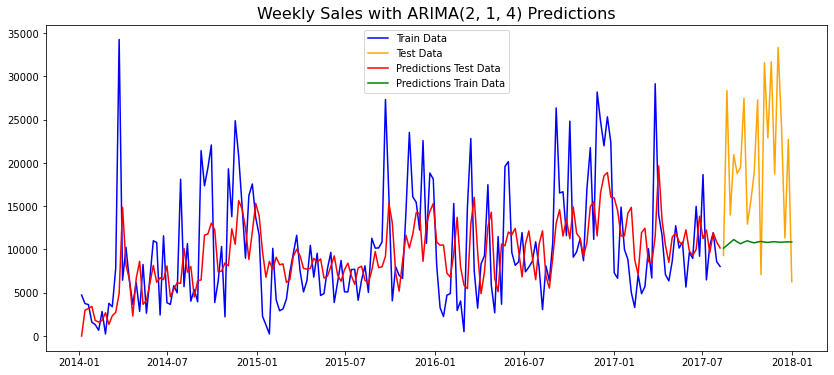

In [195]:
mean_squared_error(y_train, preds_train), mean_squared_error(y_test, preds_test)

# Plot data.
plt.figure(figsize=(14,6))

# Plot training data.
plt.plot(y_train.index, pd.DataFrame(y_train), color = 'blue', label = 'Train Data')

# Plot testing data.
plt.plot(y_test.index, pd.DataFrame(y_test), color = 'orange', label = 'Test Data')

# Plot predicted test values.
plt.plot(y_train.index, preds_train, color = 'red', label = 'Predictions Test Data')
plt.plot(y_test.index, preds_test, color = 'green', label = 'Predictions Train Data')

plt.title(label = 'Weekly Sales with ARIMA(2, 1, 4) Predictions', fontsize=16)
plt.legend()
plt.show();

In [196]:
# Accuracy metrics
def forecast_accuracy(forecast, actual):
    mape = np.mean(np.abs(forecast - actual)/np.abs(actual))  # MAPE
    mean = np.mean(forecast - actual)             # ME
    mae = np.mean(np.abs(forecast - actual))    # MAE
    mpe = np.mean((forecast - actual)/actual)   # MPE
    rmse = np.mean((forecast - actual)**2)**.5  # RMSE
    corr = np.corrcoef(forecast, actual)[0,1]   # corr
    mins = np.amin(np.hstack([forecast[:,None], 
                              actual[:,None]]), axis=1)
    maxs = np.amax(np.hstack([forecast[:,None], 
                              actual[:,None]]), axis=1)
    minmax = 1 - np.mean(mins/maxs)             # minmax
    return({'mape':mape, 'mean':mean, 'mae': mae, 
            'mpe': mpe, 'rmse':rmse,
            'corr':corr, 'minmax':minmax})

forecast_accuracy(preds_test, y_test.values)

#> {'mape': 0.02250131357314834,
#>  'me': 3.230783108990054,
#>  'mae': 4.548322194530069,
#>  'mpe': 0.016421001932706705,
#>  'rmse': 6.373238534601827,
#>  'acf1': 0.5105506325288692,
#>  'corr': 0.9674576513924394,
#>  'minmax': 0.02163154777672227}

{'mape': 0.4616724010868577,
 'mean': -9325.029541648155,
 'mae': 10206.902710745378,
 'mpe': -0.33208774291111626,
 'rmse': 12226.168958432854,
 'corr': 0.09414238841186148,
 'minmax': 0.43762774561806583}

In [197]:
df['ARIMA_214'] = automodel.predict(len(df))

df.head()

,Sales,ARIMA,SARIMAX,ARIMA_214,ARIMA_200
Order Date,,,,,
2014-01-06,4731.144,10150.876492,NaN,10150.876492,10150.876492
2014-01-13,3746.267,10472.103693,NaN,10472.103693,10472.103693
2014-01-20,3629.202,10811.561560,NaN,10811.561560,10811.561560
2014-01-27,1595.188,11144.052675,NaN,11144.052675,11144.052675
2014-02-03,1312.752,10887.387669,NaN,10887.387669,10887.387669


In [198]:
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                  Sales   No. Observations:                  188
Model:                 ARIMA(2, 1, 4)   Log Likelihood               -1891.824
Date:                Thu, 28 Apr 2022   AIC                           3797.648
Time:                        11:55:59   BIC                           3820.265
Sample:                    01-06-2014   HQIC                          3806.812
                         - 08-07-2017                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.0491      0.143     -0.343      0.732      -0.330       0.232
ar.L2         -0.7080      0.108     -6.582      0.000      -0.919      -0.497
ma.L1         -0.6066      0.152     -3.992      0.000      -0.904      -0.309
ma.L2          0.5963      0.144      4.134      0.000       0.314       0.879
ma.L3         -0.5781      0.100     -5.773      0.000      -0.774      -0.382
ma.L4         -0.2698      0.091     -2.972      0.003      -0.448      -0.092
sigma2      3.555e+07   1.34e-09   2.65e+16      0.000    3.56e+07    3.56e+07
===================================================================================
Ljung-Box (L1) (Q):                   0.03   Jarque-Bera (JB):                90.59
Prob(Q):                              0.87   Prob(JB):                         0.00
Heteroskedasticity (H):               0.85   Skew:                             1.13
Prob(H) (two-sided):                  0.54   Kurtosis:                         5.55
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
[2] Covariance matrix is singular or near-singular, with condition number 6.07e+32. Standard errors may be unstable.
"""

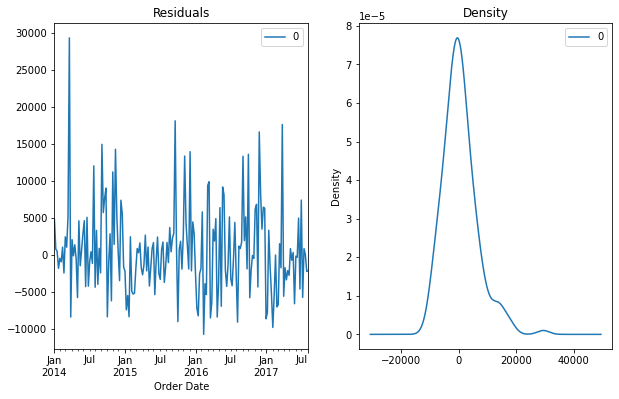

In [199]:
# Plot residual errors
residuals = pd.DataFrame(model.resid)
fig, ax = plt.subplots(1,2)
residuals.plot(title="Residuals", ax=ax[0])
residuals.plot(kind='kde', title='Density', ax=ax[1])
plt.show()

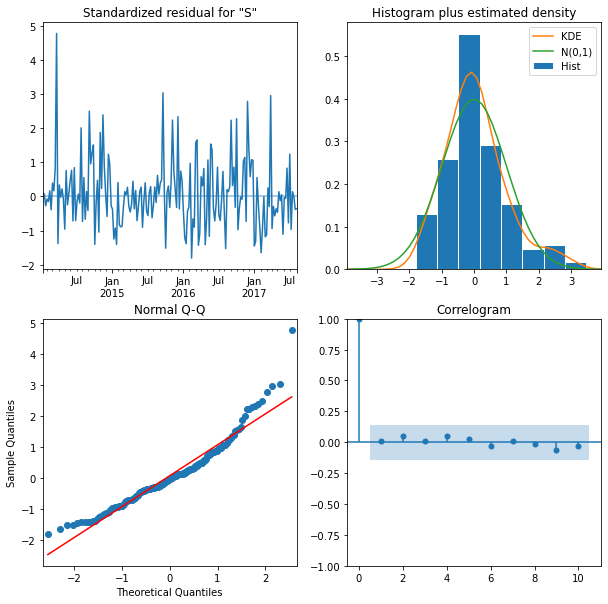

In [200]:
# https://www.machinelearningplus.com/time-series/arima-model-time-series-forecasting-python/

model.plot_diagnostics(figsize=(10,10))
plt.show()

## Arima #2 (2,0,0)

In [201]:
# Instatiate
arima = ARIMA(endog=y_train, order=(2,0,0))
model = arima.fit()

# # Preds
preds_train = model.predict(start=y_train.index[0], end=y_train.index[-1])
preds_test = model.predict(start=y_test.index[0], end=y_test.index[-1])

# # Evaluation
prediction_counter = 0
actual_counter = 0
for i in range(0, 11):
    print(f'{str(preds_test.index[i])[:10]} Predicted: {round(preds_test[i])}  Actual: {round(y_test[i])} Difference: {round((preds_test[i] / y_test[i]),2)}') 
    prediction_counter += preds_test[i]
    actual_counter += y_test[i]
    
f'prediction vs actuals: {prediction_counter / actual_counter}'

2017-08-14 Predicted: 9132  Actual: 9309 Difference: 0.98
2017-08-21 Predicted: 9428  Actual: 28383 Difference: 0.33
2017-08-28 Predicted: 9674  Actual: 13987 Difference: 0.69
2017-09-04 Predicted: 9797  Actual: 20971 Difference: 0.47
2017-09-11 Predicted: 9871  Actual: 18787 Difference: 0.53
2017-09-18 Predicted: 9913  Actual: 19501 Difference: 0.51
2017-09-25 Predicted: 9937  Actual: 27476 Difference: 0.36
2017-10-02 Predicted: 9951  Actual: 12927 Difference: 0.77
2017-10-09 Predicted: 9959  Actual: 15563 Difference: 0.64
2017-10-16 Predicted: 9963  Actual: 18906 Difference: 0.53
2017-10-23 Predicted: 9966  Actual: 27291 Difference: 0.37


'prediction vs actuals: 0.5048804550760232'

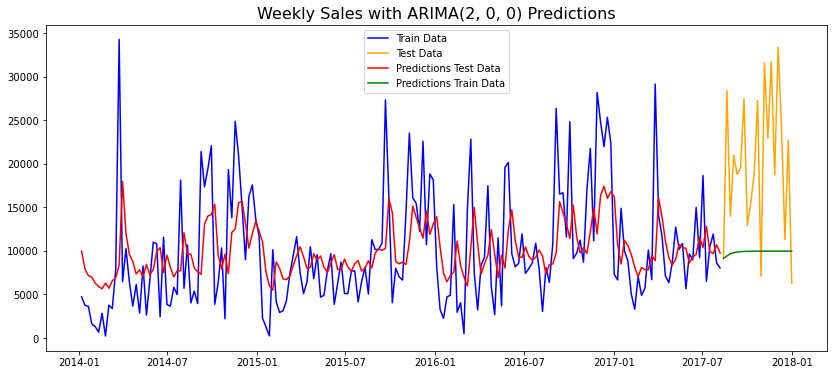

In [202]:
mean_squared_error(y_train, preds_train), mean_squared_error(y_test, preds_test)

# Plot data.
plt.figure(figsize=(14,6))

# Plot training data.
plt.plot(y_train.index, pd.DataFrame(y_train), color = 'blue', label = 'Train Data')

# Plot testing data.
plt.plot(y_test.index, pd.DataFrame(y_test), color = 'orange', label = 'Test Data')

# Plot predicted test values.
plt.plot(y_train.index, preds_train, color = 'red', label = 'Predictions Test Data')
plt.plot(y_test.index, preds_test, color = 'green', label = 'Predictions Train Data')

plt.title(label = 'Weekly Sales with ARIMA(2, 0, 0) Predictions', fontsize=16)
plt.legend()
plt.show();

In [203]:
# Accuracy metrics
def forecast_accuracy(forecast, actual):
    mape = np.mean(np.abs(forecast - actual)/np.abs(actual))  # MAPE
    mean = np.mean(forecast - actual)             # ME
    mae = np.mean(np.abs(forecast - actual))    # MAE
    mpe = np.mean((forecast - actual)/actual)   # MPE
    rmse = np.mean((forecast - actual)**2)**.5  # RMSE
    corr = np.corrcoef(forecast, actual)[0,1]   # corr
    mins = np.amin(np.hstack([forecast[:,None], 
                              actual[:,None]]), axis=1)
    maxs = np.amax(np.hstack([forecast[:,None], 
                              actual[:,None]]), axis=1)
    minmax = 1 - np.mean(mins/maxs)             # minmax
    return({'mape':mape, 'mean':mean, 'mae': mae, 
            'mpe': mpe, 'rmse':rmse,
            'corr':corr, 'minmax':minmax})

forecast_accuracy(preds_test, y_test.values)

#> {'mape': 0.02250131357314834,
#>  'me': 3.230783108990054,
#>  'mae': 4.548322194530069,
#>  'mpe': 0.016421001932706705,
#>  'rmse': 6.373238534601827,
#>  'acf1': 0.5105506325288692,
#>  'corr': 0.9674576513924394,
#>  'minmax': 0.02163154777672227}

{'mape': 0.4854718545741263,
 'mean': -10272.399656005993,
 'mae': 10897.233074249962,
 'mpe': -0.3909760014642242,
 'rmse': 12951.063978043136,
 'corr': 0.18364174636291886,
 'minmax': 0.4695649654924815}

In [204]:
df['ARIMA_200'] = automodel.predict(len(df))

df.head()

,Sales,ARIMA,SARIMAX,ARIMA_214,ARIMA_200
Order Date,,,,,
2014-01-06,4731.144,10150.876492,NaN,10150.876492,10150.876492
2014-01-13,3746.267,10472.103693,NaN,10472.103693,10472.103693
2014-01-20,3629.202,10811.561560,NaN,10811.561560,10811.561560
2014-01-27,1595.188,11144.052675,NaN,11144.052675,11144.052675
2014-02-03,1312.752,10887.387669,NaN,10887.387669,10887.387669


In [205]:
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                  Sales   No. Observations:                  188
Model:                 ARIMA(2, 0, 0)   Log Likelihood               -1902.633
Date:                Thu, 28 Apr 2022   AIC                           3813.266
Time:                        11:56:06   BIC                           3826.212
Sample:                    01-06-2014   HQIC                          3818.511
                         - 08-07-2017                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const       9969.1683    843.623     11.817      0.000    8315.698    1.16e+04
ar.L1          0.3404      0.070      4.874      0.000       0.204       0.477
ar.L2          0.1329      0.070      1.904      0.057      -0.004       0.270
sigma2      3.627e+07      0.174   2.09e+08      0.000    3.63e+07    3.63e+07
===================================================================================
Ljung-Box (L1) (Q):                   0.00   Jarque-Bera (JB):                79.92
Prob(Q):                              0.99   Prob(JB):                         0.00
Heteroskedasticity (H):               0.83   Skew:                             1.22
Prob(H) (two-sided):                  0.46   Kurtosis:                         5.06
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
[2] Covariance matrix is singular or near-singular, with condition number 2.13e+23. Standard errors may be unstable.
"""

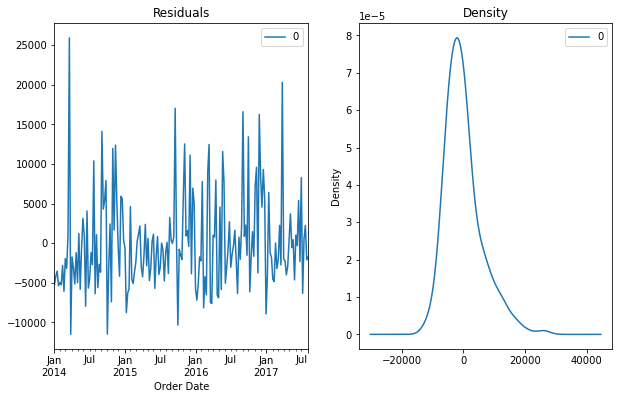

In [206]:
# Plot residual errors
residuals = pd.DataFrame(model.resid)
fig, ax = plt.subplots(1,2)
residuals.plot(title="Residuals", ax=ax[0])
residuals.plot(kind='kde', title='Density', ax=ax[1])
plt.show()

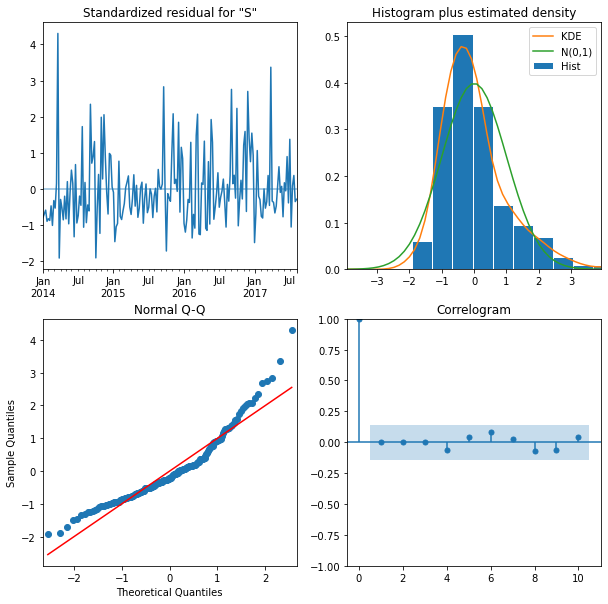

In [207]:
# https://www.machinelearningplus.com/time-series/arima-model-time-series-forecasting-python/

model.plot_diagnostics(figsize=(10,10))
plt.show()

## ARIMA #3 (52, 0, 1)

In [208]:
# Instatiate
arima = ARIMA(endog=y_train, order=(52,0,1))
model = arima.fit()

# # Preds
preds_train = model.predict(start=y_train.index[0], end=y_train.index[-1])
preds_test = model.predict(start=y_test.index[0], end=y_test.index[-1])

# # Evaluation
prediction_counter = 0
actual_counter = 0
for i in range(0, 11):
    print(f'{str(preds_test.index[i])[:10]} Predicted: {round(preds_test[i])}  Actual: {round(y_test[i])} Difference: {round((preds_test[i] / y_test[i]),2)}') 
    prediction_counter += preds_test[i]
    actual_counter += y_test[i]
    
f'prediction vs actuals: {prediction_counter / actual_counter}'

2017-08-14 Predicted: 11715  Actual: 9309 Difference: 1.26
2017-08-21 Predicted: 6281  Actual: 28383 Difference: 0.22
2017-08-28 Predicted: 10086  Actual: 13987 Difference: 0.72
2017-09-04 Predicted: 8261  Actual: 20971 Difference: 0.39
2017-09-11 Predicted: 16451  Actual: 18787 Difference: 0.88
2017-09-18 Predicted: 17511  Actual: 19501 Difference: 0.9
2017-09-25 Predicted: 14053  Actual: 27476 Difference: 0.51
2017-10-02 Predicted: 16044  Actual: 12927 Difference: 1.24
2017-10-09 Predicted: 7833  Actual: 15563 Difference: 0.5
2017-10-16 Predicted: 12100  Actual: 18906 Difference: 0.64
2017-10-23 Predicted: 14441  Actual: 27291 Difference: 0.53


'prediction vs actuals: 0.6324559355209616'

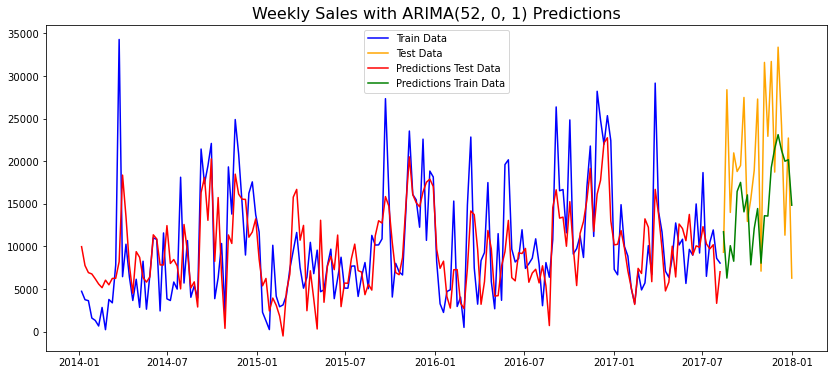

In [209]:
mean_squared_error(y_train, preds_train), mean_squared_error(y_test, preds_test)

# Plot data.
plt.figure(figsize=(14,6))

# Plot training data.
plt.plot(y_train.index, pd.DataFrame(y_train), color = 'blue', label = 'Train Data')

# Plot testing data.
plt.plot(y_test.index, pd.DataFrame(y_test), color = 'orange', label = 'Test Data')

# Plot predicted test values.
plt.plot(y_train.index, preds_train, color = 'red', label = 'Predictions Test Data')
plt.plot(y_test.index, preds_test, color = 'green', label = 'Predictions Train Data')

plt.title(label = 'Weekly Sales with ARIMA(52, 0, 1) Predictions', fontsize=16)
plt.legend()
plt.show();

In [210]:
# Accuracy metrics
def forecast_accuracy(forecast, actual):
    mape = np.mean(np.abs(forecast - actual)/np.abs(actual))  # MAPE
    mean = np.mean(forecast - actual)             # ME
    mae = np.mean(np.abs(forecast - actual))    # MAE
    mpe = np.mean((forecast - actual)/actual)   # MPE
    rmse = np.mean((forecast - actual)**2)**.5  # RMSE
    corr = np.corrcoef(forecast, actual)[0,1]   # corr
    mins = np.amin(np.hstack([forecast[:,None], 
                              actual[:,None]]), axis=1)
    maxs = np.amax(np.hstack([forecast[:,None], 
                              actual[:,None]]), axis=1)
    minmax = 1 - np.mean(mins/maxs)             # minmax
    return({'mape':mape, 'mean':mean, 'mae': mae, 
            'mpe': mpe, 'rmse':rmse,
            'corr':corr, 'minmax':minmax})

forecast_accuracy(preds_test, y_test.values)

#> {'mape': 0.02250131357314834,
#>  'me': 3.230783108990054,
#>  'mae': 4.548322194530069,
#>  'mpe': 0.016421001932706705,
#>  'rmse': 6.373238534601827,
#>  'acf1': 0.5105506325288692,
#>  'corr': 0.9674576513924394,
#>  'minmax': 0.02163154777672227}

{'mape': 0.405874179355349,
 'mean': -5376.305287657124,
 'mae': 7895.014731681075,
 'mpe': -0.12897953316527058,
 'rmse': 9721.880939120843,
 'corr': 0.26968327781906787,
 'minmax': 0.3462321447896225}

In [212]:
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                  Sales   No. Observations:                  188
Model:                ARIMA(52, 0, 1)   Log Likelihood               -1861.130
Date:                Thu, 28 Apr 2022   AIC                           3832.261
Time:                        12:02:00   BIC                           4010.265
Sample:                    01-06-2014   HQIC                          3904.382
                         - 08-07-2017                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const       9969.1686   3681.507      2.708      0.007    2753.548    1.72e+04
ar.L1          0.6892      0.272      2.536      0.011       0.157       1.222
ar.L2          0.0075      0.140      0.054      0.957      -0.266       0.282
ar.L3         -0.0943      0.135     -0.697      0.486      -0.359       0.171
ar.L4         -0.0107      0.133     -0.080      0.936      -0.271       0.250
ar.L5         -0.0335      0.113     -0.297      0.766      -0.254       0.187
ar.L6          0.2482      0.116      2.146      0.032       0.021       0.475
ar.L7         -0.0856      0.144     -0.593      0.553      -0.369       0.197
ar.L8         -0.1192      0.131     -0.908      0.364      -0.376       0.138
ar.L9          0.0044      0.132      0.034      0.973      -0.254       0.263
ar.L10         0.0358      0.120      0.298      0.765      -0.199       0.271
ar.L11         0.1374      0.126      1.089      0.276      -0.110       0.385
ar.L12        -0.1988      0.136     -1.464      0.143      -0.465       0.067
ar.L13         0.0255      0.143      0.179      0.858      -0.254       0.305
ar.L14         0.1794      0.107      1.670      0.095      -0.031       0.390
ar.L15        -0.0949      0.125     -0.756      0.449      -0.341       0.151
ar.L16         0.0437      0.115      0.379      0.705      -0.182       0.270
ar.L17        -0.0261      0.134     -0.195      0.846      -0.289       0.237
ar.L18        -0.0222      0.125     -0.178      0.859      -0.267       0.222
ar.L19         0.0103      0.123      0.084      0.933      -0.231       0.251
ar.L20         0.0082      0.114      0.072      0.943      -0.215       0.232
ar.L21        -0.0250      0.130     -0.193      0.847      -0.279       0.229
ar.L22        -0.0399      0.124     -0.323      0.747      -0.283       0.203
ar.L23        -0.1056      0.124     -0.854      0.393      -0.348       0.137
ar.L24         0.1373      0.112      1.228      0.220      -0.082       0.357
ar.L25         0.0769      0.111      0.690      0.490      -0.142       0.295
ar.L26        -0.1085      0.109     -0.995      0.320      -0.322       0.105
ar.L27         0.1022      0.102      0.998      0.318      -0.098       0.303
ar.L28        -0.2146      0.108     -1.986      0.047      -0.426      -0.003
ar.L29         0.3001      0.101      2.967      0.003       0.102       0.498
ar.L30        -0.0121      0.118     -0.103      0.918      -0.242       0.218
ar.L31        -0.3266      0.126     -2.583      0.010      -0.574      -0.079
ar.L32         0.1765      0.133      1.328      0.184      -0.084       0.437
ar.L33        -0.0193      0.128     -0.152      0.879      -0.269       0.231
ar.L34         0.1706      0.115      1.482      0.138      -0.055       0.396
ar.L35        -0.1381      0.128     -1.078      0.281      -0.389       0.113
ar.L36        -0.0683      0.132     -0.516      0.606      -0.327       0.191
ar.L37         0.1125      0.131      0.859      0.390      -0.144       0.369
ar

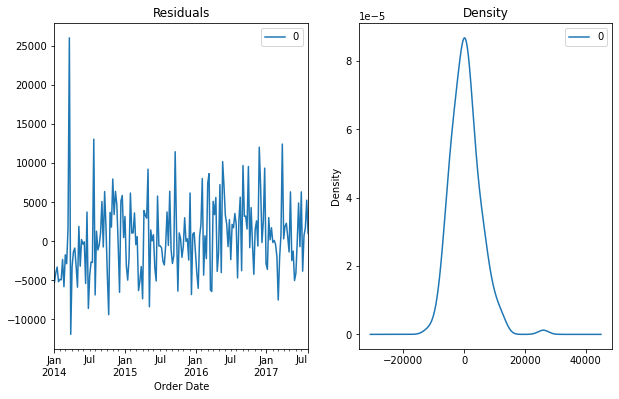

In [213]:
# Plot residual errors
residuals = pd.DataFrame(model.resid)
fig, ax = plt.subplots(1,2)
residuals.plot(title="Residuals", ax=ax[0])
residuals.plot(kind='kde', title='Density', ax=ax[1])
plt.show()

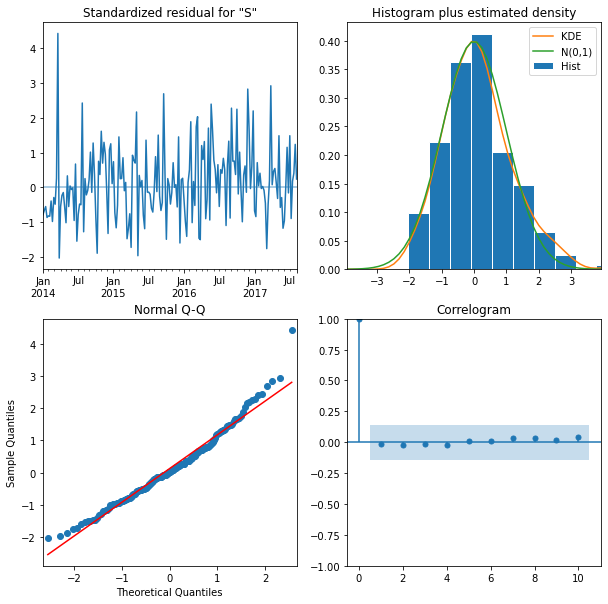

In [214]:
# https://www.machinelearningplus.com/time-series/arima-model-time-series-forecasting-python/

model.plot_diagnostics(figsize=(10,10))
plt.show()

# SARIMAX

## SARIMAX AUTO

In [215]:
# !pip3 install pyramid-arima
import pmdarima as pm

# Seasonal - fit stepwise auto-ARIMA
smodel = pm.auto_arima(y_train, start_p=1, start_q=1,
                         test='adf',
                         max_p=3, max_q=3, m=12,
                         start_P=0, seasonal=True,
                         d=None, D=1, trace=True,
                         error_action='ignore',  
                         suppress_warnings=True, 
                         stepwise=True)

smodel.summary()

Performing stepwise search to minimize aic
 ARIMA(1,0,1)(0,1,1)[12] intercept   : AIC=inf, Time=2.06 sec
 ARIMA(0,0,0)(0,1,0)[12] intercept   : AIC=3715.049, Time=0.13 sec
 ARIMA(1,0,0)(1,1,0)[12] intercept   : AIC=3627.405, Time=1.43 sec
 ARIMA(0,0,1)(0,1,1)[12] intercept   : AIC=inf, Time=1.50 sec
 ARIMA(0,0,0)(0,1,0)[12]             : AIC=3713.649, Time=0.12 sec
 ARIMA(1,0,0)(0,1,0)[12] intercept   : AIC=3698.730, Time=0.04 sec
 ARIMA(1,0,0)(2,1,0)[12] intercept   : AIC=3633.332, Time=6.30 sec
 ARIMA(1,0,0)(1,1,1)[12] intercept   : AIC=3604.286, Time=2.23 sec
 ARIMA(1,0,0)(0,1,1)[12] intercept   : AIC=inf, Time=1.65 sec
 ARIMA(1,0,0)(2,1,1)[12] intercept   : AIC=3625.612, Time=15.89 sec
 ARIMA(1,0,0)(1,1,2)[12] intercept   : AIC=3626.236, Time=20.24 sec
 ARIMA(1,0,0)(0,1,2)[12] intercept   : AIC=3605.093, Time=43.12 sec
 ARIMA(1,0,0)(2,1,2)[12] intercept   : AIC=inf, Time=52.13 sec
 ARIMA(0,0,0)(1,1,1)[12] intercept   : AIC=inf, Time=1.45 sec
 ARIMA(2,0,0)(1,1,1)[12] intercept   : A

<class 'statsmodels.iolib.summary.Summary'>
"""
                                      SARIMAX Results                                       
============================================================================================
Dep. Variable:                                    y   No. Observations:                  188
Model:             SARIMAX(2, 0, 0)x(1, 1, [1], 12)   Log Likelihood               -1795.469
Date:                              Thu, 28 Apr 2022   AIC                           3602.937
Time:                                      12:07:23   BIC                           3621.960
Sample:                                           0   HQIC                          3610.653
                                              - 188                                         
Covariance Type:                                opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept    697.9665    204.091      3.420      0.001     297.956    1097.977
ar.L1          0.3187      0.093      3.422      0.001       0.136       0.501
ar.L2          0.0642      0.086      0.747      0.455      -0.104       0.233
ar.S.L12      -0.1623      0.103     -1.571      0.116      -0.365       0.040
ma.S.L12      -0.7559      0.097     -7.802      0.000      -0.946      -0.566
sigma2      4.686e+07      0.000   9.68e+10      0.000    4.69e+07    4.69e+07
===================================================================================
Ljung-Box (L1) (Q):                   1.31   Jarque-Bera (JB):                18.22
Prob(Q):                              0.25   Prob(JB):                         0.00
Heteroskedasticity (H):               1.22   Skew:                             0.75
Prob(H) (two-sided):                  0.46   Kurtosis:                         3.49
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
[2] Covariance matrix is singular or near-singular, with condition number 3.71e+26. Standard errors may be unstable.
"""

## SARIMAX (2,0,2)(1,1,1,52)

In [227]:
# Instatiate
sarimax = SARIMAX(endog=y_train, order=(2,0,2), seasonal_order=(1, 1, 1, 52))
model = sarimax.fit()

# Preds
preds_train = model.predict(start=y_train.index[0], end=y_train.index[-1])
preds_test = model.predict(start=y_test.index[0], end=y_test.index[-1])

# Evaluation
prediction_counter = 0
actual_counter = 0
for i in range(0, 11):
    # print(f'{str(preds_test.index[i])[:10]} Predicted: {round(preds_test[i])}  Actual: {round(y_test[i])} Difference: {round((preds_test[i] / y_test[i]),2)}') 
    prediction_counter += preds_test[i]
    actual_counter += y_test[i]
    
f'prediction vs actuals: {prediction_counter / actual_counter}'

RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            7     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  7.40925D+00    |proj g|=  2.98744D-01


 This problem is unconstrained.



At iterate    5    f=  7.36901D+00    |proj g|=  3.71911D-02

At iterate   10    f=  7.36391D+00    |proj g|=  7.62908D-03

At iterate   15    f=  7.35674D+00    |proj g|=  1.46639D-01

At iterate   20    f=  7.34870D+00    |proj g|=  1.44503D-01

At iterate   25    f=  7.34825D+00    |proj g|=  5.28008D-04

At iterate   30    f=  7.34823D+00    |proj g|=  1.02793D-02

At iterate   35    f=  7.34747D+00    |proj g|=  3.41663D-02

At iterate   40    f=  7.34744D+00    |proj g|=  1.07600D-03

At iterate   45    f=  7.34744D+00    |proj g|=  1.15957D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    7     45     53   

'prediction vs actuals: 0.681606897549882'

In [228]:
# Accuracy metrics
def forecast_accuracy(forecast, actual):
    mape = np.mean(np.abs(forecast - actual)/np.abs(actual))  # MAPE
    mean = np.mean(forecast - actual)             # ME
    mae = np.mean(np.abs(forecast - actual))    # MAE
    mpe = np.mean((forecast - actual)/actual)   # MPE
    rmse = np.mean((forecast - actual)**2)**.5  # RMSE
    corr = np.corrcoef(forecast, actual)[0,1]   # corr
    mins = np.amin(np.hstack([forecast[:,None], 
                              actual[:,None]]), axis=1)
    maxs = np.amax(np.hstack([forecast[:,None], 
                              actual[:,None]]), axis=1)
    minmax = 1 - np.mean(mins/maxs)             # minmax
    return({'mape':mape, 'mean':mean, 'mae': mae, 
            'mpe': mpe, 'rmse':rmse,
            'corr':corr, 'minmax':minmax})

forecast_accuracy(preds_test, y_test.values)

#> {'mape': 0.02250131357314834,
#>  'me': 3.230783108990054,
#>  'mae': 4.548322194530069,
#>  'mpe': 0.016421001932706705,
#>  'rmse': 6.373238534601827,
#>  'acf1': 0.5105506325288692,
#>  'corr': 0.9674576513924394,
#>  'minmax': 0.02163154777672227}

{'mape': 0.3890776423267943,
 'mean': -4628.466412307763,
 'mae': 7815.082572099903,
 'mpe': -0.11031465317441908,
 'rmse': 9614.471808473581,
 'corr': 0.27011900228643115,
 'minmax': 0.34064807057547575}

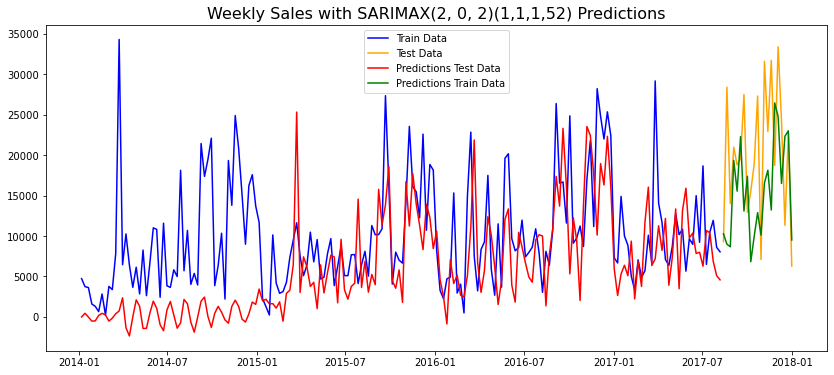

In [229]:
# Plot data.
plt.figure(figsize=(14,6))

# Plot training data.
plt.plot(y_train.index, pd.DataFrame(y_train), color = 'blue', label = 'Train Data')

# Plot testing data.
plt.plot(y_test.index, pd.DataFrame(y_test), color = 'orange', label = 'Test Data')

# Plot predicted test values.
plt.plot(y_train.index, preds_train, color = 'red', label = 'Predictions Test Data')
plt.plot(y_test.index, preds_test, color = 'green', label = 'Predictions Train Data')

plt.title(label = 'Weekly Sales with SARIMAX(2, 0, 2)(1,1,1,52) Predictions', fontsize=16)
plt.legend()
plt.show();

In [230]:
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                      SARIMAX Results                                       
============================================================================================
Dep. Variable:                                Sales   No. Observations:                  188
Model:             SARIMAX(2, 0, 2)x(1, 1, [1], 52)   Log Likelihood               -1381.318
Date:                              Thu, 28 Apr 2022   AIC                           2776.636
Time:                                      12:17:22   BIC                           2797.025
Sample:                                  01-06-2014   HQIC                          2784.921
                                       - 08-07-2017                                         
Covariance Type:                                opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.5592      0.041     13.681      0.000       0.479       0.639
ar.L2         -0.9787      0.029    -33.760      0.000      -1.036      -0.922
ma.L1         -0.4934      0.037    -13.487      0.000      -0.565      -0.422
ma.L2          0.9873      0.095     10.436      0.000       0.802       1.173
ar.S.L52      -0.4190      0.300     -1.396      0.163      -1.007       0.169
ma.S.L52       0.1723      0.349      0.494      0.621      -0.511       0.856
sigma2      4.815e+07   6.26e-09   7.69e+15      0.000    4.81e+07    4.81e+07
===================================================================================
Ljung-Box (L1) (Q):                   3.00   Jarque-Bera (JB):                13.43
Prob(Q):                              0.08   Prob(JB):                         0.00
Heteroskedasticity (H):               1.83   Skew:                             0.36
Prob(H) (two-sided):                  0.05   Kurtosis:                         4.36
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
[2] Covariance matrix is singular or near-singular, with condition number 2.5e+31. Standard errors may be unstable.
"""

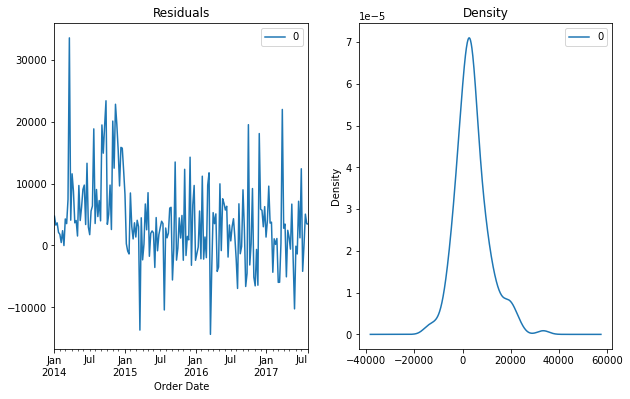

In [231]:
# Plot residual errors
residuals = pd.DataFrame(model.resid)
fig, ax = plt.subplots(1,2)
residuals.plot(title="Residuals", ax=ax[0])
residuals.plot(kind='kde', title='Density', ax=ax[1])
plt.show()

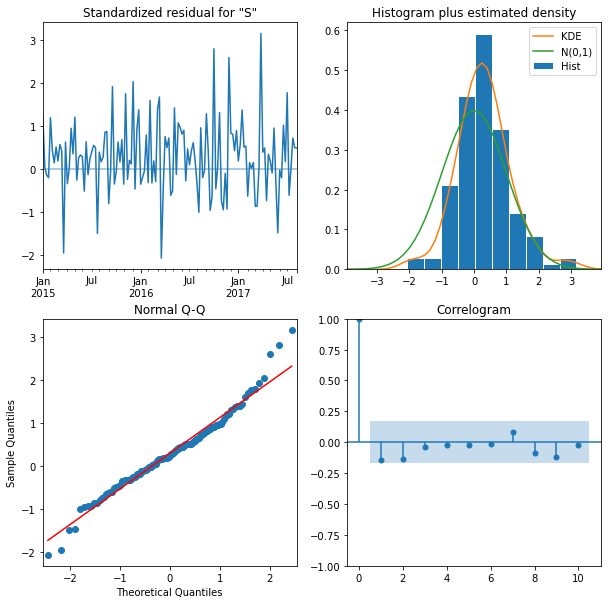

In [232]:
# https://www.machinelearningplus.com/time-series/arima-model-time-series-forecasting-python/

model.plot_diagnostics(figsize=(10,10))
plt.show()

## SARIMAX #2 (2,0,0)(1,1,1,12)

In [221]:
# Instatiate
sarimax = SARIMAX(endog=y_train, order=(2,0,0), seasonal_order=(1, 1, 1, 12))
model = sarimax.fit()

# Preds
preds_train = model.predict(start=y_train.index[0], end=y_train.index[-1])
preds_test = model.predict(start=y_test.index[0], end=y_test.index[-1])

# Evaluation
prediction_counter = 0
actual_counter = 0
for i in range(0, 11):
    # print(f'{str(preds_test.index[i])[:10]} Predicted: {round(preds_test[i])}  Actual: {round(y_test[i])} Difference: {round((preds_test[i] / y_test[i]),2)}') 
    prediction_counter += preds_test[i]
    actual_counter += y_test[i]
    
f'prediction vs actuals: {prediction_counter / actual_counter}'

RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            5     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  9.63846D+00    |proj g|=  7.96782D-02

At iterate    5    f=  9.61199D+00    |proj g|=  1.14570D-02

At iterate   10    f=  9.61161D+00    |proj g|=  5.19290D-05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    5     10     12      1     0     0   5.193D-05   9.612D+00
  F =   9.6116127930832551     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             


 This problem is unconstrained.


'prediction vs actuals: 0.5305520893003125'

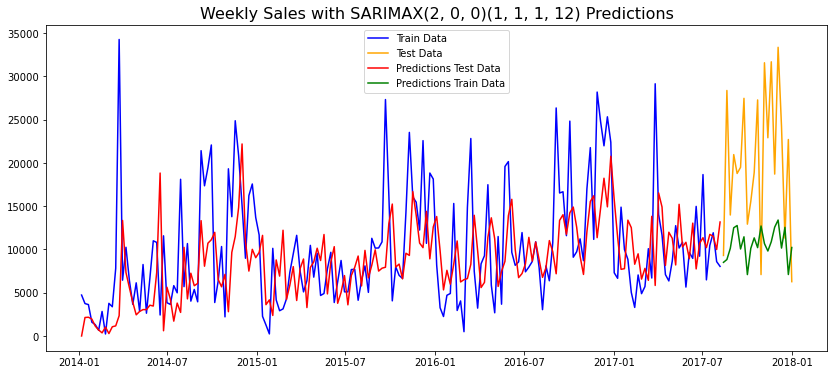

In [222]:
# Plot data.
plt.figure(figsize=(14,6))

# Plot training data.
plt.plot(y_train.index, pd.DataFrame(y_train), color = 'blue', label = 'Train Data')

# Plot testing data.
plt.plot(y_test.index, pd.DataFrame(y_test), color = 'orange', label = 'Test Data')

# Plot predicted test values.
plt.plot(y_train.index, preds_train, color = 'red', label = 'Predictions Test Data')
plt.plot(y_test.index, preds_test, color = 'green', label = 'Predictions Train Data')

plt.title(label = 'Weekly Sales with SARIMAX(2, 0, 0)(1, 1, 1, 12) Predictions', fontsize=16)
plt.legend()
plt.show();

In [223]:
# Accuracy metrics
def forecast_accuracy(forecast, actual):
    mape = np.mean(np.abs(forecast - actual)/np.abs(actual))  # MAPE
    mean = np.mean(forecast - actual)             # ME
    mae = np.mean(np.abs(forecast - actual))    # MAE
    mpe = np.mean((forecast - actual)/actual)   # MPE
    rmse = np.mean((forecast - actual)**2)**.5  # RMSE
    corr = np.corrcoef(forecast, actual)[0,1]   # corr
    mins = np.amin(np.hstack([forecast[:,None], 
                              actual[:,None]]), axis=1)
    maxs = np.amax(np.hstack([forecast[:,None], 
                              actual[:,None]]), axis=1)
    minmax = 1 - np.mean(mins/maxs)             # minmax
    return({'mape':mape, 'mean':mean, 'mae': mae, 
            'mpe': mpe, 'rmse':rmse,
            'corr':corr, 'minmax':minmax})

forecast_accuracy(preds_test, y_test.values)

#> {'mape': 0.02250131357314834,
#>  'me': 3.230783108990054,
#>  'mae': 4.548322194530069,
#>  'mpe': 0.016421001932706705,
#>  'rmse': 6.373238534601827,
#>  'acf1': 0.5105506325288692,
#>  'corr': 0.9674576513924394,
#>  'minmax': 0.02163154777672227}

{'mape': 0.4895091419544408,
 'mean': -9513.257767446537,
 'mae': 10542.57155097434,
 'mpe': -0.34377569114622836,
 'rmse': 12402.459062579115,
 'corr': 0.0900794797951954,
 'minmax': 0.4607750627556315}

In [224]:
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                      SARIMAX Results                                       
============================================================================================
Dep. Variable:                                Sales   No. Observations:                  188
Model:             SARIMAX(2, 0, 0)x(1, 1, [1], 12)   Log Likelihood               -1806.983
Date:                              Thu, 28 Apr 2022   AIC                           3623.966
Time:                                      12:10:38   BIC                           3639.819
Sample:                                  01-06-2014   HQIC                          3630.396
                                       - 08-07-2017                                         
Covariance Type:                                opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.3843      0.147      2.611      0.009       0.096       0.673
ar.L2          0.1586      0.137      1.154      0.248      -0.111       0.428
ar.S.L12      -0.1328      0.162     -0.822      0.411      -0.450       0.184
ma.S.L12      -0.7800      0.163     -4.773      0.000      -1.100      -0.460
sigma2      7.565e+07   1.06e-09   7.11e+16      0.000    7.56e+07    7.56e+07
===================================================================================
Ljung-Box (L1) (Q):                   0.02   Jarque-Bera (JB):                22.75
Prob(Q):                              0.88   Prob(JB):                         0.00
Heteroskedasticity (H):               1.07   Skew:                             0.75
Prob(H) (two-sided):                  0.80   Kurtosis:                         3.93
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
[2] Covariance matrix is singular or near-singular, with condition number 1.51e+32. Standard errors may be unstable.
"""

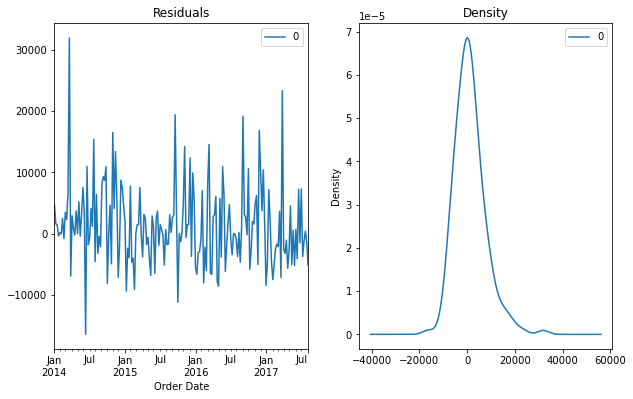

In [225]:
# Plot residual errors
residuals = pd.DataFrame(model.resid)
fig, ax = plt.subplots(1,2)
residuals.plot(title="Residuals", ax=ax[0])
residuals.plot(kind='kde', title='Density', ax=ax[1])
plt.show()

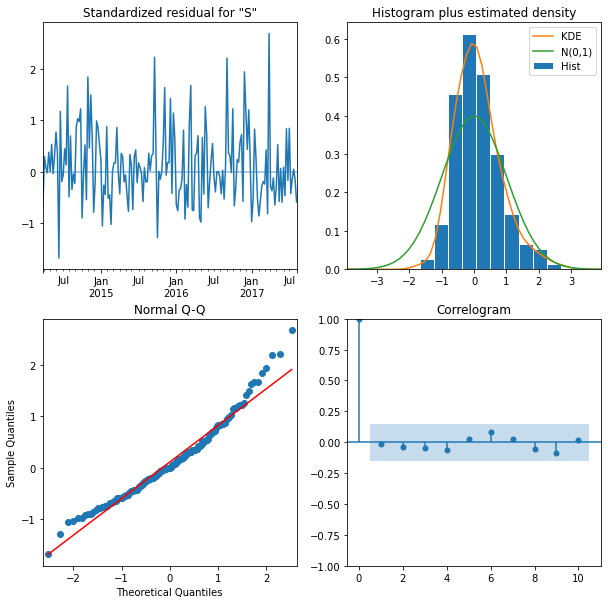

In [226]:
# https://www.machinelearningplus.com/time-series/arima-model-time-series-forecasting-python/

model.plot_diagnostics(figsize=(10,10))
plt.show()